In [1]:
from skimage import io, transform
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from dataLoader import OrganoidDataset
from torch.utils import data
import numpy as np
import sys
import pandas as pd

from dataLoader import OrganoidDataset
from conv_model import SimpleConvNet
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

params = {'batch_size': 64, # low for testing
          'shuffle': True, 'num_workers' : 4}
max_epochs = 100

In [3]:
use_cuda

True

In [4]:

import pandas 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

params = {'batch_size': 100, # low for testing
  'shuffle': True, 'num_workers' : 4}

max_epochs = 200

path = '../data/CS231n_Tim_Shan_example_data/'
well_descriptions = pandas.read_csv('filtered_well_descriptions.txt', header=0)
day1wells = well_descriptions['well_id']
day1wells = day1wells[well_descriptions['day'] == 1]
day1wells.shape
day13wells = well_descriptions['well_id']
day13wells = day13wells[well_descriptions['day'] == 13]
day13wells.shape
daysLabel = pandas.Series(list(set(day13wells) & set(day1wells)))


well_labels = []
for i in range(daysLabel.shape[0]):
  i2str = str(daysLabel[i])
  if len(i2str) == 1:
    i2str = '000' + i2str
  if len(i2str) == 2:
    i2str = '00' + i2str
  if len(i2str) == 3:
    i2str = '0' + i2str
  well_labels.append(i2str)

day_label_X = ['01']*len(well_labels)
n = len(well_labels)

finalSizes = well_descriptions['hyst2_area']
finalSizes = finalSizes[np.logical_and(well_descriptions['day'] == 13, np.isin(well_descriptions['well_id'], daysLabel))].values

day1_mean_and_var = pandas.read_csv('day1_mean_and_var.txt', sep = '\t', header = 0)

initial_train_set = OrganoidDataset(path2files = path, well_labels = well_labels, day_label_X = day_label_X, Y = finalSizes, intensity_mean = day1_mean_and_var['mean'][0], intensity_var = day1_mean_and_var['variance'][0])
training_generator = data.DataLoader(initial_train_set, **params)


In [5]:
TOTAL = n

# preprocess data 

In [12]:
label_path = '../data/well_summary_A1_e0891BSA_all.csv'

In [13]:
label = pd.read_csv(label_path)

In [14]:
new_columns = ['well_id','day','median_pixel_intensity','mw_area_shape','hyst1_area','hyst2_area']
label.columns = new_columns

In [15]:
def get_image_name(well_id,day_id):
    image_name = 'well'+str(well_id).zfill(4)+'_day'+str(day_id).zfill(2)+'_well.png'
    return image_name
def get_well_label(well_id):
    return str(well_id).zfill(4)

In [16]:
label['image_name'] = label[['well_id','day']].apply(lambda x: get_image_name(*x),axis=1)
label['well_label'] = label['well_id'].apply(lambda x: get_well_label(x))

In [17]:
label.head(2)

,well_id,day,median_pixel_intensity,mw_area_shape,hyst1_area,hyst2_area,image_name,well_label
0,0,0,125.0,7830,512,418,well0000_day00_well.png,0000
1,1,0,125.0,8265,3044,3008,well0001_day00_well.png,0001


In [18]:
label.query("mw_area_shape > 32000").sort_values(by=['well_id','day'])

,well_id,day,median_pixel_intensity,mw_area_shape,hyst1_area,hyst2_area,image_name,well_label
43203,3,9,133.0,33124,14317,13965,well0003_day09_well.png,0003
33605,5,7,144.0,33124,14895,14654,well0005_day07_well.png,0005
48005,5,10,132.0,33124,12929,12666,well0005_day10_well.png,0005
57605,5,12,135.0,33124,13279,12997,well0005_day12_well.png,0005
19207,7,4,132.0,33124,14855,14586,well0007_day04_well.png,0007
43223,23,9,133.0,33124,17816,17288,well0023_day09_well.png,0023
33625,25,7,144.0,33124,20824,19976,well0025_day07_well.png,0025
43225,25,9,127.0,33124,23727,23129,well0025_day09_well.png,0025
52825,25,11,128.0,33124,29729,29134,well0025_day11_well.png,0025
14430,30,3,143.0,33124,13660,13486,well0030_day03_well.png,0030


In [19]:
excluded_well_id = set(label.query("mw_area_shape >= 32000")['well_id'].tolist())

In [20]:
len(excluded_well_id)

1510

In [21]:
label.isin(excluded_well_id).shape

(67200, 8)

In [22]:
corrected_labels = label.query("mw_area_shape < 32000")

In [ ]:
# def normalize_label()

In [24]:
hyst1_areacorrected_labels['hyst1_area'].std()

1072.6403020126638

In [23]:
corrected_labels['hyst1_area'] = corrected_labels['hyst1_area']/(corrected_labels['hyst1_area'].std())
corrected_labels['hyst2_area'] = corrected_labels['hyst2_area']/(corrected_labels['hyst2_area'].std())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
corrected_labels.to_csv('filtered_well_descriptions.txt')

In [25]:
day1wells = corrected_labels.query("day == 1")
day13wells = corrected_labels.query("day == 13")

In [26]:
day1wells.shape, day13wells.shape

((4721, 8), (4712, 8))

In [27]:
merged_days = day1wells.merge(day13wells, on=['well_label'],suffixes=['_1','_13'])

In [28]:
merged_days.shape

(4642, 15)

In [29]:
well_labels = merged_days['well_label']
finalSizes = merged_days['hyst2_area_13']

In [30]:
# for i in range(4800):
#     well_labels.append(str(i).zfill(4))

In [46]:
NUM_TRAIN = 4000
TOTAL = merged_days.shape[0]
NUM_VAL = TOTAL-NUM_TRAIN

In [47]:
training_set = merged_days[:NUM_TRAIN]
val_set = merged_days[NUM_TRAIN:]

In [48]:
train_well_labels = training_set['well_label']
train_size = training_set['hyst2_area_13']

val_well_labels = val_set['well_label']
val_size =val_set['hyst2_area_13']

In [49]:
path = '../data/CS231n_Tim_Shan_example_data/'
initial_train_set = OrganoidDataset(path2files = path, well_labels = train_well_labels, day_label_X = ['01']*NUM_TRAIN, Y = train_size)
# training_generator = data.DataLoader(initial_train_set,  batch_size=64, 
#                           sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

In [109]:

training_generator = data.DataLoader(initial_train_set, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

In [110]:
validation_set =OrganoidDataset(path2files = path, well_labels = val_well_labels, day_label_X = ['01']*NUM_VAL, Y = val_size)
validation_generator = data.DataLoader(initial_train_set, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

In [112]:
initial_train_set = OrganoidDataset(path2files = path, well_labels = well_labels, day_label_X = ['01']*TOTAL, Y = finalSizes)
training_generator = data.DataLoader(initial_train_set, **params)

In [82]:

# NUM_TRAIN = 49000
# loader_train = DataLoader(training_generator, batch_size=64, 
#                           sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# MODEL

In [6]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [7]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


In [14]:
model = model.to(device=device)

In [8]:
all_errors=[]
def check_accuracy_part34(loader, model):
#     if loader.dataset.train:
#         print('Checking accuracy on validation set')
#     else:
#         print('Checking accuracy on test set')   
    error = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            preds = model(x)
            #_, preds = scores.max(1)
            #num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            error += (y-preds)**2
        acc = float(error) / num_samples
        all_errors.append(acc)
        print('Got accuracy (%.2f)' % (error, num_samples, 100 * acc))

In [21]:
def train_part34(model, optimizer, epochs=1):
    train_errors = {}
    losses = {}
    for e in range(epochs):
        print(e)
        totalbatchMSE = 0.0
        for t, (x, y) in enumerate(training_generator):
            #print('epoch: ',e)
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            Y_hat = model(x)
            #loss = nn.MSELoss(Y_hat,y)
            loss = F.mse_loss(Y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_error = loss.item()
            totalbatchMSE = totalbatchMSE + params['batch_size']*train_error/TOTAL
            train_errors[t] = totalbatchMSE
            losses[t] = train_error
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, train_error))
                print("total_batch_mse",totalbatchMSE)
                #check_accuracy_part34(training_generator, model)
    return train_errors,losses
    

In [10]:

out_size = 1
in_channels = 1 
channel_1 = 32
channel_2 = 16
out_size = 1
image_size = 193
model = nn.Sequential(
    nn.Conv2d(in_channels=in_channels,out_channels=channel_1,kernel_size=5,padding=2,bias=True),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel_1,out_channels=channel_2,kernel_size=3,padding=1,bias=True),
    nn.ReLU(),   
    Flatten(),
    nn.Linear(channel_2*image_size*image_size, out_size,bias=True),
)

In [11]:
model.cuda()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten()
  (5): Linear(in_features=595984, out_features=1, bias=True)
)

In [22]:
print_every = 100
epoches = 10
learning_rate = 1e-2

#optimizer =optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_errors,losses = train_part34(model, optimizer,epochs=epoches)


0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  del sys.path[0]


Iteration 0, loss = 1.5057
total_batch_mse 0.032437168694117724
1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  del sys.path[0]


Iteration 0, loss = 1.7565
total_batch_mse 0.037840004883568534
2
Iteration 0, loss = 2.1729
total_batch_mse 0.04681010844120945
3
Iteration 0, loss = 2.7671
total_batch_mse 0.05961040236322287
4
Iteration 0, loss = 1.5960
total_batch_mse 0.0343807937255557
5
Iteration 0, loss = 0.6200
total_batch_mse 0.013356556002819452
6
Iteration 0, loss = 1.7859
total_batch_mse 0.03847334724929198
7
Iteration 0, loss = 3.5306
total_batch_mse 0.07605712920209037
8
Iteration 0, loss = 0.3899
total_batch_mse 0.008399584256385432
9
Iteration 0, loss = 4.3520
total_batch_mse 0.09375222537703475


In [23]:
train_errors

{0: 0.09375222537703475,
 1: 0.10336041193694608,
 2: 0.14464460226648174,
 3: 0.2133466672506994,
 4: 0.23234890278738565,
 5: 0.2672945050934377,
 6: 0.28319141182700197,
 7: 0.3496606267253575,
 8: 0.357695228192684,
 9: 0.3985479461227394,
 10: 0.43692168607531,
 11: 0.46363685766410745,
 12: 0.5076825946171394,
 13: 0.5196673911946028,
 14: 0.5271535978292607,
 15: 0.5353101891518051,
 16: 0.563701052493137,
 17: 0.6293550576695283,
 18: 0.6435430471057884,
 19: 0.7362564310643345,
 20: 0.7696015472198446,
 21: 0.7850972448428711,
 22: 0.7924047755763635,
 23: 0.8293680580255031,
 24: 0.8728666186897676,
 25: 0.8843968174982462,
 26: 0.907981345644289,
 27: 0.9185348263027237,
 28: 1.0083327341932309,
 29: 1.0142083069929941,
 30: 1.0222202986286204,
 31: 1.046056637780413,
 32: 1.0766483044018271,
 33: 1.1268383839786802,
 34: 1.1366661389240778,
 35: 1.167700166514289,
 36: 1.2097874196476592,
 37: 1.2279491847519834,
 38: 1.2677384900769406,
 39: 1.2763161865455848,
 40: 1.3264

Text(0, 0.5, 'loss')

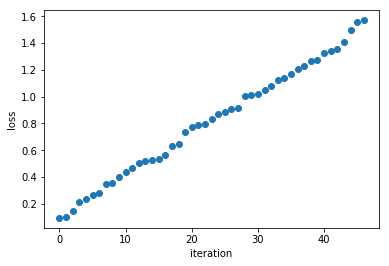

In [24]:
plt.plot(train_errors.values(), 'o')
#set_ylim(0,0.35)
plt.xlabel('iteration')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

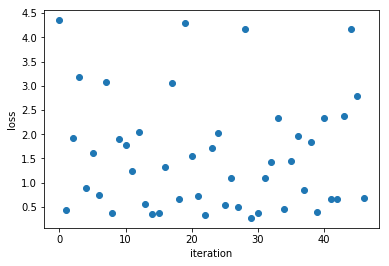

In [25]:
plt.plot(losses.values(), 'o')
#set_ylim(0,0.35)
plt.xlabel('iteration')
plt.ylabel('loss')